# Digit Classifier w/ PyTorch

We are going to do a few things here:

- We want to train a model to identify digits for the individual sudoku cell image that the Recognizer has prepared.
- We want to use this as a Tensorflow Model in the C++

So what are the steps?

1. First train the sudoku digit classifier (aka SudokuNet) model using the MNIST dataset
2. Save the model to the /models folder as a .pb file

## Part I: Setup

### Dependencies

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score

### Get the dataset

In [2]:
batch_size_train = 64
batch_size_test = 1000

In [3]:
# prep training dataset
train_dataset = torchvision.datasets.MNIST(
    './dataset', train=True, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size_train, 
    shuffle=True
)

# prep test dataset
test_dataset = torchvision.datasets.MNIST(
    './dataset', 
    train=False, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size_test, 
    shuffle=True
)

Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Plot some samples

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

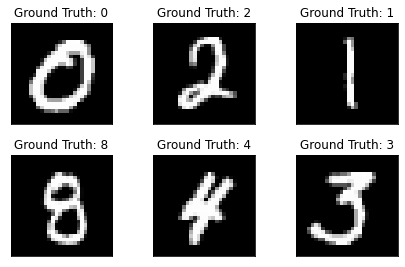

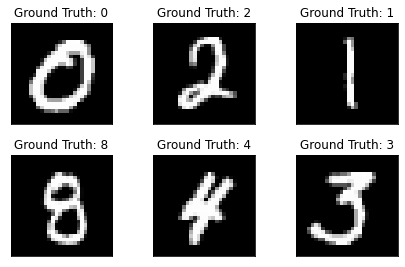

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Part II: Build the model

### Setup

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

### Create the model

In [9]:
n_epochs = 10

learning_rate = 0.01
log_interval = 10
lr_step_gamma = 0.7
momentum = 0.5
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [99]:
class SudokuNet(nn.Module):
    def __init__(self):
        super(SudokuNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv => ReLU => Pool layer
        x = self.conv1(x) 
        x = F.relu(x)
        # Conv => ReLU => Pool layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # FC => ReLU layer
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)        
        x = self.fc2(x)        
        x = F.log_softmax(x, dim=1)
        return x

### Setup training

## Part III: Train the model

In [100]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [101]:
model = SudokuNet()
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

In [102]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [103]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [104]:
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

test(model, device, test_loader)
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


Test set: Average loss: 2.3038, Accuracy: 1218/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303901
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.274816
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.247427
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.195626
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.143287
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.096818
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.026670
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.007355
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.881060
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.813629
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.675157
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.659019
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.588211
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.503697
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.254871
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.371049
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.234024
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.174105
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.162745
Train Epoch: 1 [12

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.223784
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.282470
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.601715
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.484031
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.639593
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.252745
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.468061
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.405805
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.349514
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.375045
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.587646
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.438701
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.392996
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.418708
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.405620
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.178239
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.348279
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.416172
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.332603
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.261764


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.195385
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.277692
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.184620
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.340117
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.313995
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.248699
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.384940
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.315592
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.272553
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.206337
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.557439
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.128265
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.217719
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.231252
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.278146
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.226523
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.274355
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.188053
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.311723
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.221576


Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.241253
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.234128
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.179865
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.235272
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.368603
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.196617
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.175659
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.285161
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.277303
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.263490
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.194468
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.109689
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.360437
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.275317
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.138982
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.260830
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.148492
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.258386
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.301335
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.247928


Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.150963
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.270145
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.301053
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.237640
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.116305

Test set: Average loss: 0.1688, Accuracy: 9518/10000 (95%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.268458
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.260424
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.235187
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.234846
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.139734
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.306376
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.296820
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.155886
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.466944
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.256809
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.256437
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.466259
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.354970
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.211879
Train Epoch: 8 [

Train Epoch: 9 [40960/60000 (68%)]	Loss: 0.166760
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.158393
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.269183
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.194727
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.196825
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.210046
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.352404
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.321506
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.378812
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.209408
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.275664
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.343497
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.137923
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.194991
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.506887
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.166373
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.305182
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.133670
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.240143
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.317755


## Part IV: Evaluate performance

([], [])

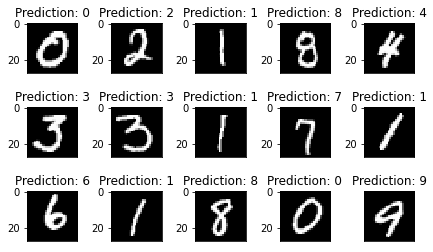

In [105]:
with torch.no_grad():
    output = model(example_data)

fig = plt.figure()
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
plt.yticks([])



### Testing

In [106]:
# /home/kosuke/Downloads/pytorch-example/test_cell1.jpg

In [107]:
print(output.data[0])
print(output.data.max(1,True)[1][0].item())

tensor([-5.0151e-04, -1.5275e+01, -1.4320e+01, -1.0792e+01, -1.6763e+01,
        -7.6835e+00, -1.4462e+01, -1.2393e+01, -1.1250e+01, -1.3183e+01])
0


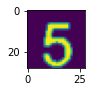

5


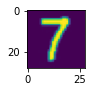

2


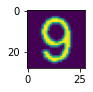

8


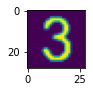

3


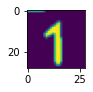

1


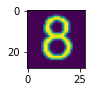

3


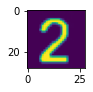

2


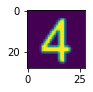

6


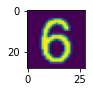

5


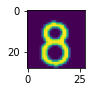

8


In [109]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
])

model.eval()

for i in range(10):
    img = Image.open(f"/home/kosuke/Downloads/pytorch-example/test_data/1/test_cell{i+1}.jpg")
    img_tensor = transform(img)
    img_tensor_array = img_tensor.unsqueeze(0)
#     img_tensor_array = img_tensor.unsqueeze(0)

    plt.subplot(2,5, i+1)
    plt.imshow(pil_image)

    pil_image = transforms.ToPILImage(mode='L')(img_tensor)
    with torch.no_grad():
        data = Variable(img_tensor_array)
    plt.imshow(pil_image)
    plt.show()
    out = model(data)
    print(out.data.max(1, keepdim=True)[1].item())

In [146]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([128, 1600])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([10, 128])
fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {140466598930328: {'step': 4690, 'square_avg': tensor([[[[4.3341e-05, 3.8368e-05, 6.2752e-05, 6.4492e-05, 2.4329e-05],
          [6.5469e-05, 7.9749e-05, 1.0045e-04, 6.3590e-05, 3.5428e-05],
          [9.5182e-05, 1.1238e-04, 1.2895e-04, 8.8450e-05, 7.3660e-05],
          [6.8761e-05, 7.0515e-05, 5.3159e-05, 5.4676e-05, 7.5723e-05],
          [5.8572e-05, 5.0048e-05, 4.0376e-05, 3.9879e-05, 4.8963e-05]]],


        [[[3.2676e-05, 6.9174e-05, 6.6171e-05, 3.4924e-05, 2.4718e-05],
          [3.9216e-05, 8.3439e-05, 4.3531e-05, 2.3949e-05, 1.6864e-05],
          [5.2054e-05, 6.1873e-05, 3.3731e-05, 2.9840e-05, 3.0642e-05],
          [6.2428e-05, 5.4302e-05, 3.1562e-05, 2.

In [147]:
example_image, example_label = next(iter(train_loader))
# run the tracing
traced_script_module = torch.jit.trace(model, example_image)
# save the converted model
traced_script_module.save("./models/converted_model.pt")